### Agente con consultas a una Base de Datos

Definimos el LLM

In [347]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()
openai_model = os.getenv("LLM_MODEL", "gpt-o4-mini")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(model= openai_model, temperature=0.5)

Hacemos la conexion con la base de datos

In [348]:
from langchain_community.utilities import SQLDatabase

username = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST", "localhost")  # Default to localhost
port = os.getenv("POSTGRES_PORT", "5432")  # Default PostgreSQL port
database = os.getenv("POSTGRES_DB", "mydatabase")  # Default database name

print(f"Connecting to database {database} at {host}:{port} as user {username}")

connection_uri = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

dbEngine = SQLDatabase.from_uri(connection_uri)
print(dbEngine.dialect)
print(dbEngine.get_usable_table_names())

Connecting to database product_marketing at localhost:5432 as user user
postgresql
['caracteristica', 'categoria', 'imagen', 'lista', 'precio', 'producto', 'producto_promocion', 'promocion', 'tipo_caracteristica', 'variante']


Usamos las herramientas proveidas por SQLDatabaseToolkit para listar las tablas

In [349]:
from langchain_core.tools import tool
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage

toolkit = SQLDatabaseToolkit(db=dbEngine, llm=llm)
tools = toolkit.get_tools()

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

def list_tables():
    """List all tables in the database."""
    return dbEngine.get_usable_table_names()

def get_schema():
    """Get the schema of the database."""
    
    return dbEngine.get_table_info()
    

list_tables_result = list_tables()
tables_schema = get_schema()

print(list_tables_result)
print(tables_schema)

['caracteristica', 'categoria', 'imagen', 'lista', 'precio', 'producto', 'producto_promocion', 'promocion', 'tipo_caracteristica', 'variante']

CREATE TABLE caracteristica (
	id UUID NOT NULL, 
	variante_id UUID, 
	tipo_id UUID, 
	valor VARCHAR NOT NULL, 
	CONSTRAINT caracteristica_pkey PRIMARY KEY (id), 
	CONSTRAINT caracteristica_tipo_id_fkey FOREIGN KEY(tipo_id) REFERENCES tipo_caracteristica (id), 
	CONSTRAINT caracteristica_variante_id_fkey FOREIGN KEY(variante_id) REFERENCES variante (id)
)

/*
3 rows from caracteristica table:
id	variante_id	tipo_id	valor
eb0e385d-7518-4b7f-a2b2-070b5189f9ca	dbb5128c-a6cf-48ef-96fc-4918a3e8b098	35b64ede-e314-4d10-8f1f-94873d8a50a2	16
126fec22-0f6f-47e7-9ef9-4e567bc7ce73	e3506319-3373-4a93-b4f0-c166125b8136	35b64ede-e314-4d10-8f1f-94873d8a50a2	32
85d24c29-62fe-4b0f-a581-d9a3d2846702	c0718ac6-fa97-48e7-b52a-ee2b4d8eadfb	43008b0c-a5eb-4911-957a-0f82c84842f9	White
*/


CREATE TABLE categoria (
	id UUID NOT NULL, 
	nombre VARCHAR NOT NULL, 
	CONSTRAI

Definimos el estado el cual será mutado por los nodos

In [350]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """State of the agent."""
    last_question: str
    last_query: str
    last_query_result: str 
    
    summary: str
    messages: Annotated[Sequence[BaseMessage], add_messages]

Definimos la herramienta Query a BD

In [ ]:
from langchain_core.messages import  SystemMessage, AIMessage, FunctionMessage, HumanMessage, RemoveMessage
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

@tool(return_direct=True)
def generate_query(state: AgentState) -> str :
    """" Genera un query SQL a partir de una pregunta del usuario y el schema de la base de datos. """
    question = state.get("last_question", "")
    
    generate_query_system_prompt = """
    Dada una pregunta de entrada, crea una consulta {dialect} sintácticamente correcta
    para ayudar a encontrar la respuesta. 
    Puedes ordenar los resultados por una columna relevante para devolver los ejemplos más interesantes de la base de datos.

    Nunca consultes todas las columnas de una tabla específica, solo solicita las columnas relevantes según la pregunta.

    Presta atención a usar solo los nombres de columnas que aparecen en la descripción del esquema.
    Ten cuidado de no consultar columnas que no existen. Además, asegúrate de saber qué columna pertenece a qué tabla.

    En caso de ser consultado por caracteristicas de un producto, devuelve el nombre del producto con sus variantes y sus variantes con caracteristicas y precios.

    Solo puedes usar las siguientes tablas:
    {table_info}
    """.format(
        dialect=dbEngine.dialect,
        table_info=tables_schema,
    )
    sys_message = SystemMessage(content=generate_query_system_prompt)
    structured_llm = llm.with_structured_output(QueryOutput)
    
    question_message = HumanMessage(content=question)
    response = structured_llm.invoke([sys_message]+[question_message]) # type: ignore
    query = response.get("query", "")

    return query
tools = [generate_query]

Definimos los Nodos

In [352]:
def agent(state: AgentState):
    """
    El agente determina si se necesita usar la herramienta de query o responde con la info actual.
    """
    
    question = state.get("messages")[-1].content
    last_query_result = state.get("last_query_result", "")
    last_query = state.get("last_query", "")
    
    sys_msg= """
        Eres un agente de marketing especializado en ofrecer productos y responder preguntas sobre estos.
        Cuentas con una herramienta que te permite consultar a la base de datos de productos para responder 
        preguntas del cliente, para usarla siempre debes pasar el estado actual del agente.
        Se te presentara con una pregunta la cual debes llamar a la herramienta en caso que el usuario pida 
        informacion sobre productos, variantes, caracteristicas, categorias o precios de estos
        En caso que la pregunta no sea sobre productos, responde brevemente sin usar la herramienta ofreciendo.
        En caso que si se necesita usar la herramienta, no pidas autorizacion al usuario, simplemente llama a la herramienta de consulta.
        """
    
    if  last_query_result:
        sys_msg= sys_msg + f"""
        Usando la respuesta del query anterior y el resumen actual, puedes responder a la pregunta del usuario.
        Si el sql query anterior no cubrió la pregunta del usuario, usa la herramienta para hacer un nuevo query.
        
        Anterior query: {last_query}
        Resultado del query: {last_query_result}
        Pregunta: {question}
        """
    else:
        sys_msg= sys_msg + f"""
        Si necesitas información para la pregunta usa la herramienta
        
        Pregunta: {question}
        """    
    system_message = SystemMessage(content=sys_msg)
    
    model = llm.bind_tools(tools)
    
    messages = state.get("messages", [])
    response = model.invoke(messages + [system_message])
    return {"last_question": question, "messages": [response]}

def reformulate_question(state: AgentState):
    """
    Reformula la pregunta del usuario usando el resumen actual (si existe).
    """
    question = state.get("last_question", "")
    print(f"Reformulating question: {question}")
    summary = state.get("summary", "")
    if summary:
        prompt = f"""Usando el resumen como contexto:\n{summary}\nReformula la siguiente pregunta de manera concisa:\n{question}"""
    else:
        prompt = f"Reformula la siguiente pregunta sin acentos de manera concisa:\n{question}"
    reformulated = llm.invoke([SystemMessage(content=prompt)])
    
        
    return {"messages": [], "last_question": reformulated.content}

def run_query(state: AgentState):
    """Execute SQL query."""
    messages = state.get("messages", [])
    query = str(messages[-1].content) 
    
    execute_query_tool = QuerySQLDatabaseTool(db=dbEngine)

    result = execute_query_tool.invoke(query)
    result_message = FunctionMessage(name="Sql_query", content=result)
    return {"last_query": query, "last_query_result": result, "messages": [result_message]}

def generate_response(state: AgentState):
    """Generate a response based on the last query result and the summary."""
    messages = state.get("messages", [])
    question = state.get("last_question", "")
    last_query_result = state.get("last_query_result", "")
    
    query_message = FunctionMessage(content=last_query_result, name="Sql_query")
    prompt = SystemMessage("Con el resultado del query responde al usuario de manera concisa de manera estructurada:")
    question_message = HumanMessage(content=question)
    
    response = llm.invoke([query_message, prompt, question_message]) # type: ignore
    
    return {"messages": [response]}

def summarize(state: AgentState):
    """Summarize the conversation."""
    messages = state.get("messages", [])
    summary = state.get("summary", "")
    
    if summary:
        prompt = f"Este es el resumen actual de la conversación:\n{summary}\n\nExpande el resumen incluyendo los puntos clave y las preguntas realizadas en 3 oraciones, sin incluir respuestas o resultados de consultas SQL."
    else: 
        prompt = "Resume la conversación de manera concisa y clara, incluyendo los puntos clave y las preguntas realizadas en 3 oraciones, sin incluir respuestas o resultados de consultas SQL."
        
    summary_message = HumanMessage(content=prompt)    
    summary_response = llm.invoke([summary_message] + messages) # type: ignore
    new_summary = summary_response.content
    
    delete_messages = [RemoveMessage(id=m.id) for m in messages]
    
    return {"summary": new_summary, "messages": delete_messages}

Hacemos una arista condicional

In [353]:
from langgraph.graph import END
from typing import Literal

max_messages_before_summary = 10

def summarize_condition(state: AgentState) -> Literal["summarize", END]:
    messages = state.get("messages", [])
    if len(messages) > max_messages_before_summary:
        return "summarize"
    return END

Checkpointer en sqlite

In [354]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from pathlib import Path

base_dir = Path.cwd().parent
db_path = base_dir / "Databases/checkpoints.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Construimos el grafo

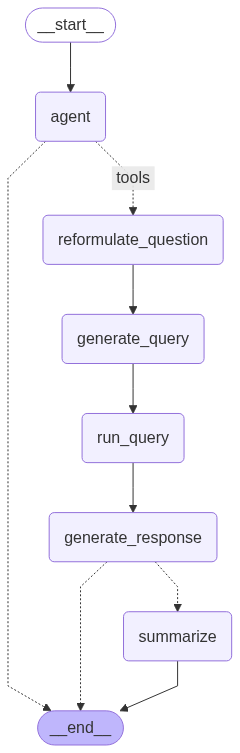

In [355]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition

generate_query_node = ToolNode([generate_query])

builder = StateGraph(AgentState)

builder.add_node("agent", agent)
builder.add_node("reformulate_question", reformulate_question)
builder.add_node("generate_query", generate_query_node)
builder.add_node("run_query", run_query)
builder.add_node("generate_response", generate_response)
builder.add_node("summarize", summarize)

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "reformulate_question",  # Si se va a usar la herramienta, primero reformula
        END: END
    }
)
builder.add_edge("reformulate_question", "generate_query")
builder.add_edge("generate_query", "run_query")
builder.add_edge("run_query", "generate_response")
builder.add_conditional_edges(
    "generate_response",
    summarize_condition,
    {
        "summarize": "summarize",
        END: END
    }
)
builder.add_edge("summarize", END)

agent = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

Pruebas

In [356]:
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from uuid import uuid4

thread_id = str(uuid4())
config = RunnableConfig(configurable={"thread_id": thread_id})

print(f"----NUEVA CONVERSACION CREADA CON ID: {thread_id} ----")
pregunta = HumanMessage(content="Buenos dias")

for step in agent.stream(
    {
        "messages": [pregunta],
    },
    config= config
): 
    for node, update in step.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n")


----NUEVA CONVERSACION CREADA CON ID: b3ae8544-c409-49dc-a98a-d624fc86ec16 ----
Update from node agent
================================== Ai Message ==================================

¡Buenos días! ¿En qué puedo ayudarte hoy? Si tienes alguna pregunta sobre productos, características o precios, estaré encantado de ayudarte.




otro mensaje

In [357]:
config = RunnableConfig(configurable={"thread_id": thread_id})
pregunta = HumanMessage(content="no tiene alguna promocion?")

for step in agent.stream(
    {
        "messages": [pregunta],
    },
    config= config
): 
    for node, update in step.items():
        print("Update from node", node)
        if len(update["messages"]) > 0:
            update["messages"][-1].pretty_print()
        print("\n")

Update from node agent
================================== Ai Message ==================================
Tool Calls:
  generate_query (call_QIlKSIIlrj5HezvGBasebZxv)
 Call ID: call_QIlKSIIlrj5HezvGBasebZxv
  Args:
    state: {'last_question': 'no tiene alguna promocion?', 'last_query': '', 'last_query_result': '', 'summary': '', 'messages': []}


Reformulating question: no tiene alguna promocion?
Update from node reformulate_question


Update from node generate_query
================================= Tool Message =================================
Name: generate_query

SELECT p.nombre, v.descripcion, c.valor, pr.precio 
FROM producto p 
JOIN variante v ON p.id = v.producto_id 
JOIN caracteristica c ON v.id = c.variante_id 
JOIN precio pr ON v.id = pr.variante_id 
LEFT JOIN producto_promocion pp ON p.id = pp.producto_id 
WHERE pp.id IS NULL 
ORDER BY p.nombre;


Update from node run_query
=============================== Function Message ===============================
Name: Sql_query

[('